In [1]:
#reference GAN https://github.com/daymos/simple_keras_GAN/blob/master/gan.py
#reference WGAN https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py

In [31]:
import os
#os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 10

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(128, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(256))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator = Sequential()
discriminator.add(Dense(512, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    print('randomDim: ', randomDim)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 10 == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 50
Batch size: 128
Batches per epoch: 468.75
randomDim:  10
--------------- Epoch 1 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:39<00:00, 11.81it/s]


--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 13.93it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:31<00:00, 15.72it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.01it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 15.78it/s]


--------------- Epoch 6 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 16.39it/s]


--------------- Epoch 7 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 16.39it/s]


--------------- Epoch 8 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 15.98it/s]


--------------- Epoch 9 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 16.44it/s]


--------------- Epoch 10 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 16.40it/s]


--------------- Epoch 11 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 14.46it/s]


--------------- Epoch 12 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:31<00:00, 16.16it/s]


--------------- Epoch 13 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:29<00:00, 16.80it/s]


--------------- Epoch 14 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.31it/s]


--------------- Epoch 15 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.37it/s]


--------------- Epoch 16 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.19it/s]


--------------- Epoch 17 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.36it/s]


--------------- Epoch 18 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 15.98it/s]


--------------- Epoch 19 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.66it/s]


--------------- Epoch 20 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 15.79it/s]


--------------- Epoch 21 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.32it/s]


--------------- Epoch 22 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.60it/s]


--------------- Epoch 23 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:28<00:00, 16.53it/s]


--------------- Epoch 24 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.06it/s]


--------------- Epoch 25 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 12.73it/s]


--------------- Epoch 26 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 12.38it/s]


--------------- Epoch 27 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:34<00:00, 13.60it/s]


--------------- Epoch 28 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.24it/s]


--------------- Epoch 29 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 15.38it/s]


--------------- Epoch 30 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:34<00:00, 13.48it/s]


--------------- Epoch 31 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 13.00it/s]


--------------- Epoch 32 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.72it/s]


--------------- Epoch 33 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.82it/s]


--------------- Epoch 34 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 15.43it/s]


--------------- Epoch 35 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:34<00:00, 13.72it/s]


--------------- Epoch 36 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.69it/s]


--------------- Epoch 37 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 15.10it/s]


--------------- Epoch 38 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.92it/s]


--------------- Epoch 39 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.02it/s]


--------------- Epoch 40 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:30<00:00, 15.26it/s]


--------------- Epoch 41 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.67it/s]


--------------- Epoch 42 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.67it/s]


--------------- Epoch 43 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:33<00:00, 14.93it/s]


--------------- Epoch 44 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.95it/s]


--------------- Epoch 45 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:33<00:00, 13.16it/s]


--------------- Epoch 46 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 15.43it/s]


--------------- Epoch 47 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.25it/s]


--------------- Epoch 48 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:34<00:00, 14.61it/s]


--------------- Epoch 49 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.48it/s]


--------------- Epoch 50 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:32<00:00, 14.77it/s]


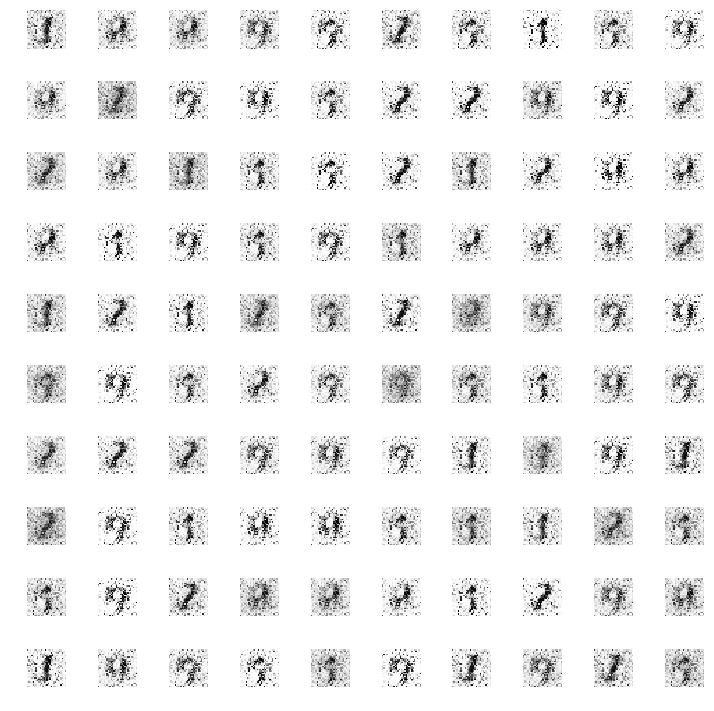

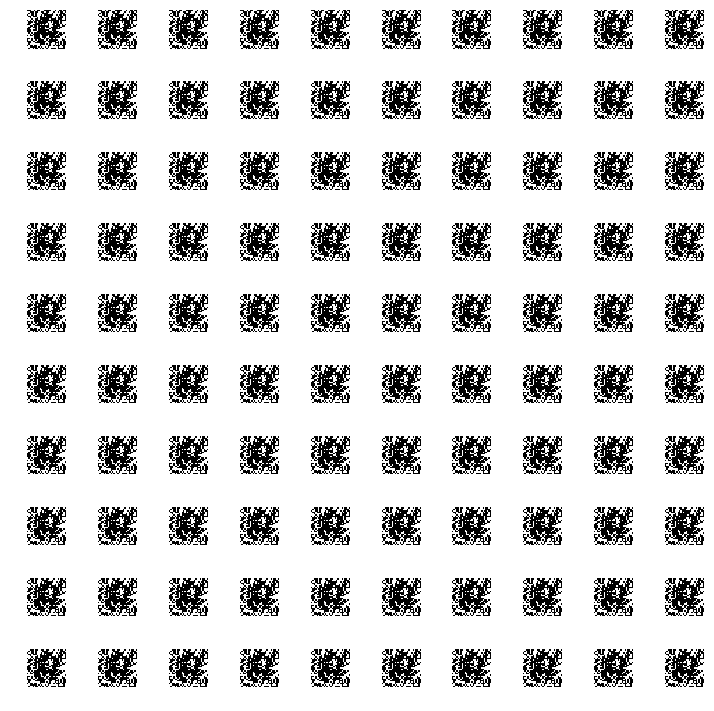

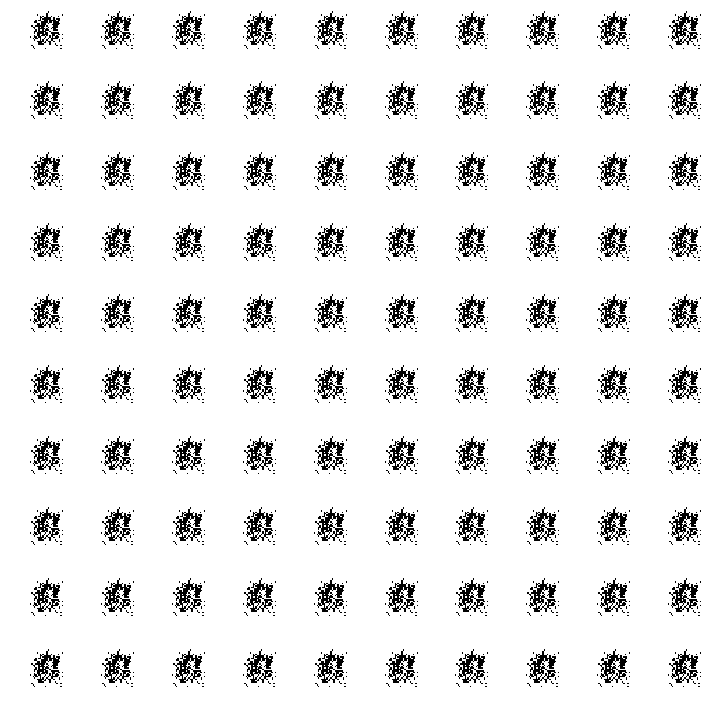

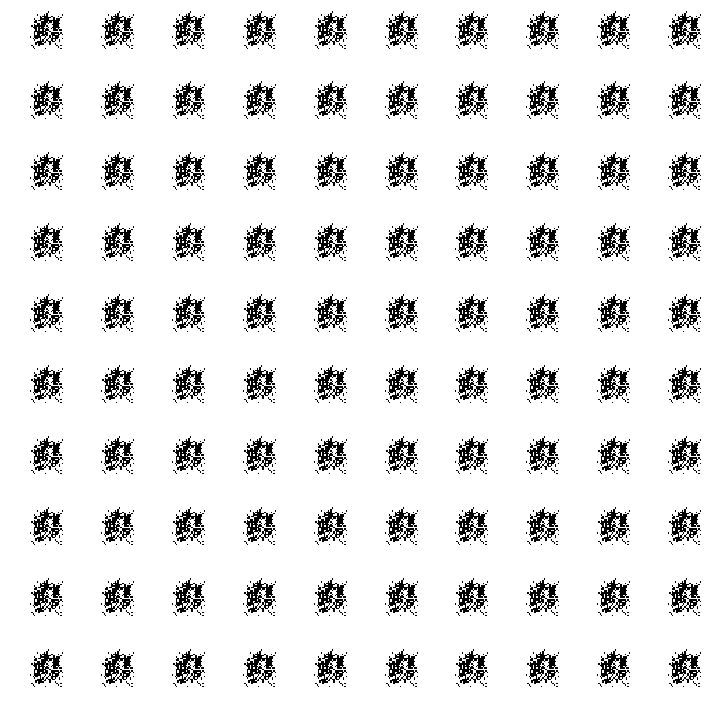

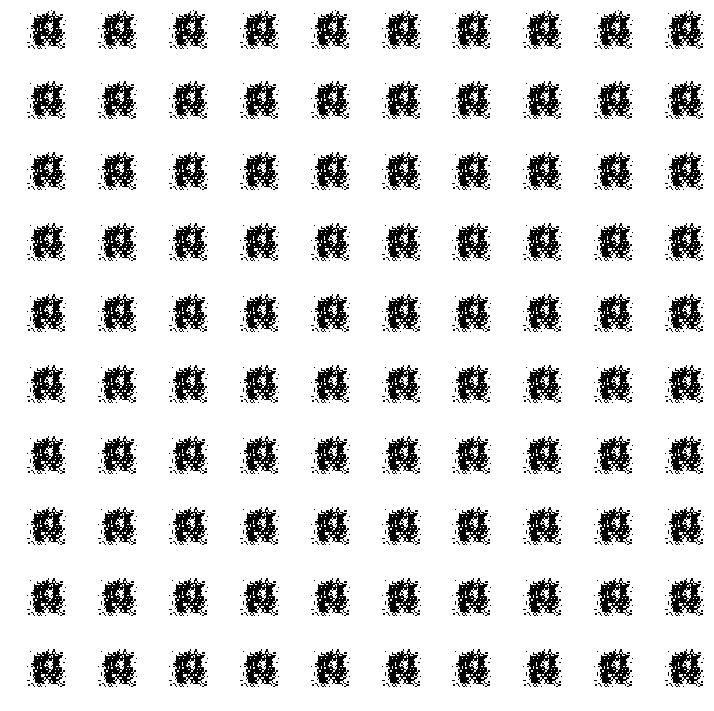

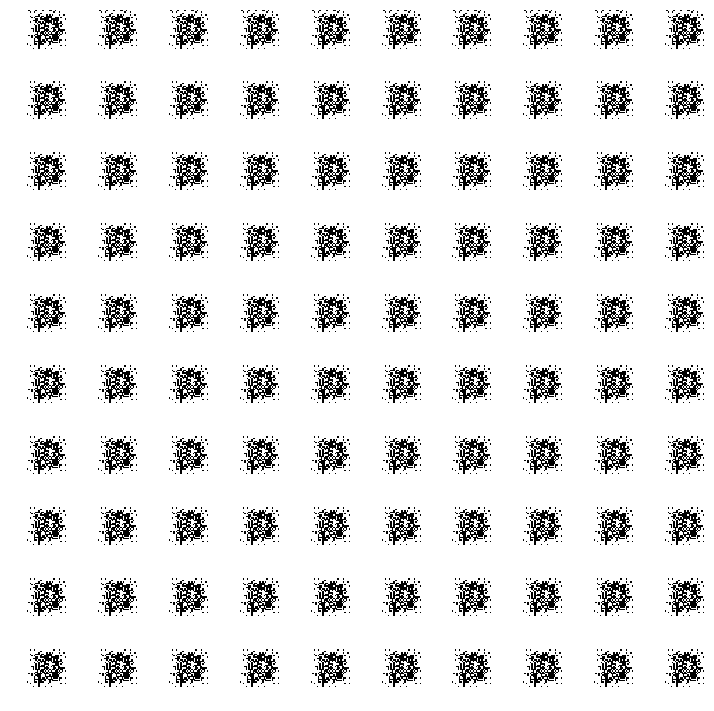

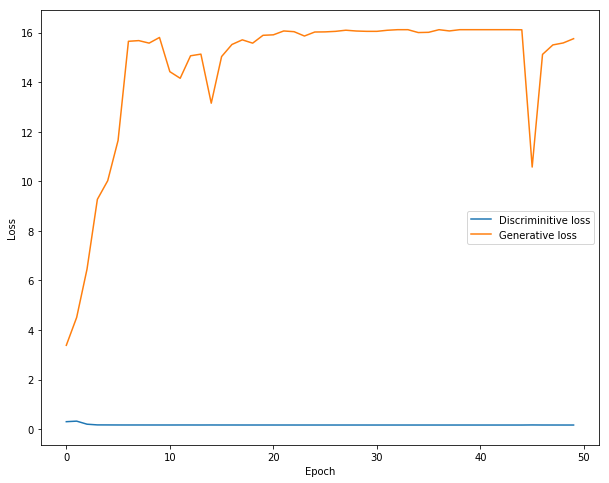

In [32]:
train(50, 128)

In [33]:
def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="Discriminator")
    plt.plot(iterations, test, label="Generator")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

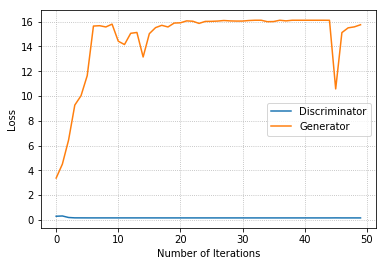

In [34]:
plotLoss(dLosses, gLosses)

In [ ]:
def photogallery(photos):
    fig = plt.figure(figsize=(4, 12))
    for i, entry in enumerate(photos):
        ax1 = fig.add_subplot(10,2,i*2+1)
        ax1.imshow(entry[0])
        ax2 = fig.add_subplot(10,2,i*2+2)
        ax2.imshow(entry[1])

In [ ]:
np.random.seed(42)
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
photos = []

print("original, vae")
for digit in digits:
    index0 = np.where(y_test==digit)[0]
    pick = index0[np.random.choice(index0.shape[0])]
    #digit_indexes.append(pick)
    #print(pick)
    #print(im_shape)
    original = x_test[pick].reshape(32, 32, 3)
    encoded = x_test_encoded[pick].reshape(32, 32,3)
    photos.append([original, encoded])
    
photogallery(photos)

In [35]:
def plotGeneratedImages(epoch, examples=40, dim=(10, 4), figsize=(10, 4)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure()
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap=plt.cm.gray)
        plt.axis('off')
    #plt.tight_layout()
    plt.show()
    #plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

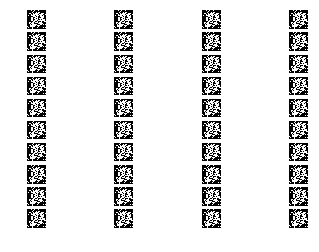

In [36]:
plotGeneratedImages(50)